# Fallow from the Other Side

In this assignment you will examine fallow patterns in the state of California. "Fallowing" is when a land is left uncropped for one or more season, usually for the purpose of preserving soil health. You have two years of Cropland Data Layer (CDL), 2017 and 2018, from which to examine how common the phenomenon is in the Central Valley of California. 

__NOTE__: you will need to make use of the CDL documentation to answer many of these questions.


1. Clip the 2017 and 2018 CDL rasters of the Central Valley to the state of California. Plot both rasters next to each other with the California shapefile. __(2 points)__
2. Summarize the top land uses in California in each year. Specifically, make the following categorization using the CDL documentation to summarize the pixels in each year: 
    - Crops (including Fallowed Land)
    - Forest
    - Grassland/Pasture
    - Shrubland
    - Developed Land
    - Other
    
  For the category "Crops," make an additional graph showing the decomposition of this category in each year. __(2 points)__
3. Create two rasters for each year: 
    - 1 if pixel is cropped, 0 otherwise
    - 1 if pixel is fallowed, 0 otherwise
    
   And then plot all four of them with the shape file of California.  __(2 points)__
4. Describe the degree of fallowing rotation between 2017 and 2018. How much crop land became fallowed? How much fallow land became cropped? Make a table or figure that conveys this information. __(2 points)__
5. Create a raster using the CDL layers where each pixel is labeled: 
    - 1 = crop stayed crop
    - 2 = fallowed stayed fallowed
    - 3 = crop changed to fallowed
    - 4 = fallowed changed to crop
    - 0 = any other case.
    
    Then visualize the raster on top of the California shapefile. Note any patterns you see in land use change and your thoughts on the cause of the patterns. __(4 points)__
    
    __BONUS GRAPH__: To submit your graph for one extra credit points, please put a markdown cell above your graph code that says "__My Submission__"  

6. Using the `rasterstats` package, calculate the county-level percentage of crop/fallow pixels which transitioned from fallow to crops and vice-versa. Make two [choropleth maps](https://en.wikipedia.org/wiki/Choropleth_map) of the county-averages for these two variables. __(4 points)__ __Hint: you will need to use a keyword called "nodata" to correctly do the calculation.__

__Extra Credit__ (1 point)
Read in the PRISM annual precipitation raster for 2017 and calculate the county-level average for precipitation in that year. Calculate the correlation between these annual rainfall measures and the two measures you calculated above at the county level.


7. Suppose we want to answer the following question (__4 points__):
    
    __"What effect did rainfall in 2017 have on conversion of fallowed land to crop land in 2018?"__
   
   Describe how you might answer this question, specifically:
       - What data sources you would need in addition to the data you have now.
       - How you would manipulate the data.
       - What statistics you would calculate or model you would run on this data.
       - How you might present your findings.
       
    Finally, what factors would make it difficult to accurately answer this question? List three and explain why they might make answering the question difficult. 


# Atharva Rajadnya
asr6@illinois.edu

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pyproj
import rasterio
import rasterstats
import pandas as pd
import json
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.colors as pltc
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import zonal_stats

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

# 1

<AxesSubplot:>

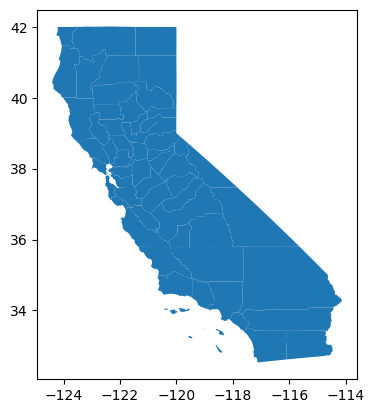

In [4]:
# Plotting rasters with California shapefile

counties = gpd.read_file("us_counties_2017.shp")
CA = counties[counties.STATEFP=="06"]

CA.plot()

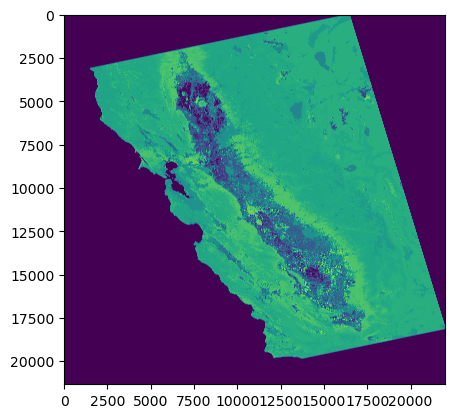

In [5]:
# Reading raster files

r17 = rasterio.open("Central_Valley_CDL_2017_clip.tif")
r18 = rasterio.open("Central_Valley_CDL_2018_clip.tif")

plt.imshow(r17.read(1))

In [6]:
# Comparing CRS

r17.crs==CA.crs

False

In [7]:
# Printing CRS

r17.crs,CA.crs

(CRS.from_epsg(4326),
 <Geographic 2D CRS: EPSG:4269>
 Name: NAD83
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Is

In [8]:
# Reprojecting

CA = CA.to_crs(r17.crs)

In [9]:
# Clipping the raster 

CA_State = CA.dissolve(by="STATEFP", aggfunc="sum")

def clip_raster(raster,vector,filename):
    img_out, img_transform = mask(raster,getFeatures(vector),crop=True)
    
    out_meta = raster.meta.copy()

    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = img_transform

    with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open("./"+filename+".tif")

r17_c = clip_raster(r17,CA_State,"CA17_CDL")
r18_c = clip_raster(r18,CA_State,"CA18_CDL")

Text(0.5, 1.0, '2018')

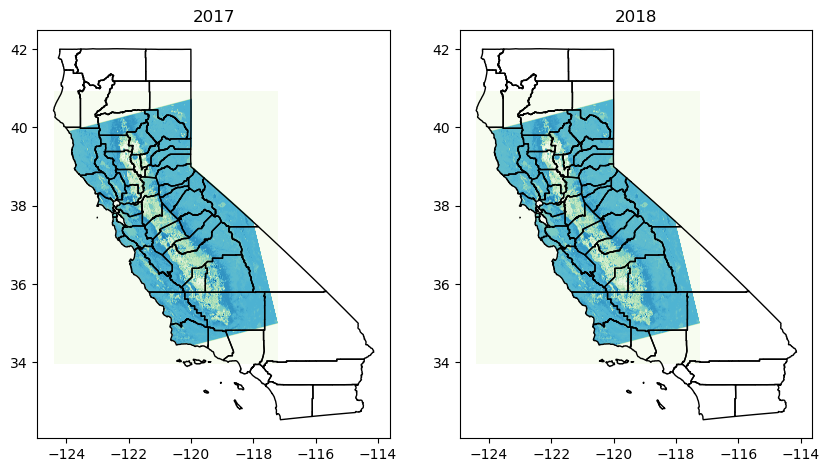

In [10]:
# Plotting

fig, ax = plt.subplots(1,2,figsize=(10, 20))
show(r17_c, ax=ax[0],cmap="GnBu")

CA.plot(ax=ax[0], facecolor='none', edgecolor='black')
ax[0].set_title("2017")
show(r18_c, ax=ax[1],cmap="GnBu")

CA.plot(ax=ax[1], facecolor='none', edgecolor='black')
ax[1].set_title("2018")

# 2

In [11]:
# Reading in files

with open("us_states.json") as f:
    pix_names = json.load(f)
    
r17_array = r17_c.read(1)
r18_array = r18_c.read(1)

In [12]:
# Summarizing top land uses

pix17 = pd.Series(r17_array.flatten())
pix17 = pix17[pix17!=0]
pix_counts17 = pix17.value_counts()

pix18 = pd.Series(r18_array.flatten())
pix18 = pix18[pix18!=0]
pix_counts18 = pix18.value_counts()

pix_counts = pd.concat([pix_counts18,pix_counts17],axis=1).fillna(0)

pix_counts.columns = [2018,2017]

In [13]:
# Additional data preprocessing

pix_counts_disagg = pix_counts.reset_index()
pix_counts_disagg['index'] = pix_counts_disagg['index'].astype(str).replace(pix_names)
pix_counts_disagg = pix_counts_disagg.set_index("index")
pix_pcts_disagg = pix_counts_disagg.sort_values(by=2018,ascending=False)/ pix_counts_disagg[2017].sum()*100

pix_pcts_disagg.head(10)

,2018,2017
index,,
152,29.989653,30.397085
142,22.218781,22.118665
176,16.080141,16.757657
61,3.265307,2.609597
121,3.214165,3.237305
143,3.002037,2.693830
131,2.849790,2.734160
75,2.289379,2.631844
123,1.508999,1.508982


In [14]:
# Converting pixel values to integers

pix_counts_agg = pix_counts.reset_index()
pix_counts_agg['label'] = pix_counts_agg['index'].astype(str).replace(pix_names)
pix_counts_agg['index'] = pix_counts_agg['index'].astype(int)

# Grouping pixels

pix_counts_agg['agg_label'] = pix_counts_agg['label']

pix_counts_agg.loc[pix_counts_agg['index']<20,"agg_label"]= "Crop"
pix_counts_agg.loc[(pix_counts_agg['index']>=20)&(pix_counts_agg['index']<40),"agg_label"]= "Crop"
pix_counts_agg.loc[(pix_counts_agg['index']>=40)&(pix_counts_agg['index']<=61),"agg_label"]= "Crop"
pix_counts_agg.loc[(pix_counts_agg['index']>=62)&(pix_counts_agg['index']<66),"agg_label"]= "Other"
pix_counts_agg.loc[(pix_counts_agg['index']>=66)&(pix_counts_agg['index']<80),"agg_label"]= "Crop"
pix_counts_agg.loc[(pix_counts_agg['index']>=81)&(pix_counts_agg['index']<120),"agg_label"]= "Other"
pix_counts_agg.loc[(pix_counts_agg['index']>=120)&(pix_counts_agg['index']<125),"agg_label"]= "Developed"
pix_counts_agg.loc[(pix_counts_agg['index']>=125)&(pix_counts_agg['index']<140),"agg_label"]= "Other"
pix_counts_agg.loc[(pix_counts_agg['index']>=141)&(pix_counts_agg['index']<144),"agg_label"]= "Forest"
pix_counts_agg.loc[(pix_counts_agg['index']>=144)&(pix_counts_agg['index']<190),"agg_label"]= pix_counts_agg['label']
pix_counts_agg.loc[(pix_counts_agg['index']>=190)&(pix_counts_agg['index']<200),"agg_label"]= "Other"
pix_counts_agg.loc[(pix_counts_agg['index']>=196),"agg_label"]= "Crop"

Text(0.5, 1.0, '2018')

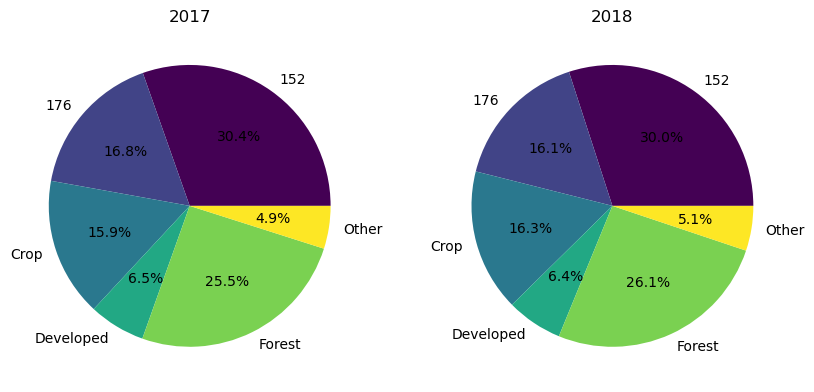

In [15]:
# Plotting 

fig, ax = plt.subplots(1,2,figsize=(10,20))

pix_counts_agg.groupby("agg_label")[2017].sum().plot(ax=ax[0],kind="pie",autopct='%1.1f%%',cmap="viridis")
pix_counts_agg.groupby("agg_label")[2018].sum().plot(ax=ax[1],kind="pie",autopct='%1.1f%%',cmap="viridis")

ax[0].set_ylabel("")
ax[0].set_title("2017")
ax[1].set_ylabel("")
ax[1].set_title("2018")

In [16]:
# Decomposition of crop category

crop_pix = pix_counts_agg[pix_counts_agg.agg_label=="Crop"]
crop_pix = crop_pix.set_index("label").sort_values(by=2017,ascending=False)
top7_labels = crop_pix.head(7).index

crop17 = crop_pix[crop_pix.index.isin(top7_labels)][2017]
crop18 = crop_pix[crop_pix.index.isin(top7_labels)][2018]

crop17["Other"] = crop_pix[~crop_pix.index.isin(top7_labels)][2017].sum()
crop18["Other"] = crop_pix[~crop_pix.index.isin(top7_labels)][2018].sum()

/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_3064/3697653616.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crop17["Other"] = crop_pix[~crop_pix.index.isin(top7_labels)][2017].sum()
/var/folders/_d/_3n207px5t7bmqg02j6l0qsc0000gn/T/ipykernel_3064/3697653616.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crop18["Other"] = crop_pix[~crop_pix.index.isin(top7_labels)][2018].sum()


Text(0.5, 1.0, '2018')

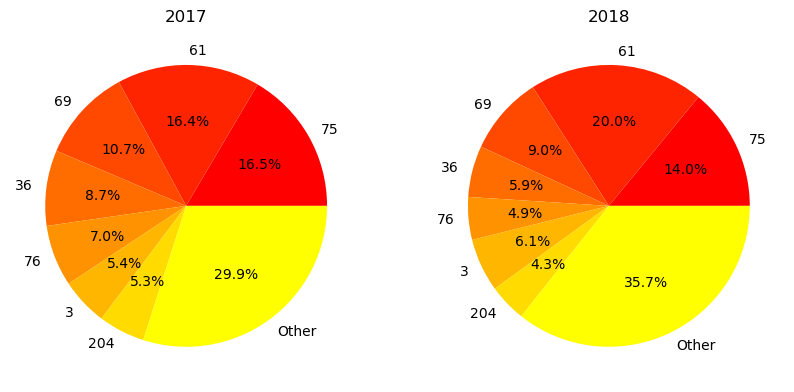

In [17]:
# Plotting split of the crop category

fig, ax = plt.subplots(1,2,figsize=(10,20))

crop17.plot(ax=ax[0],kind="pie",autopct='%1.1f%%',cmap="autumn")
crop18.plot(ax=ax[1],kind="pie",autopct='%1.1f%%',cmap="autumn")

ax[0].set_ylabel("")
ax[0].set_title("2017")
ax[1].set_ylabel("")
ax[1].set_title("2018")

# 3

In [18]:
# Cropped vs fallowed pixels

def raster_mask(raster,mask,filename):
    x = raster.read(1)
    img_out = np.zeros(x.shape) 
    
    img_out[mask] = 1 
    
    img_out = img_out[np.newaxis,:,:].astype(np.uint8)
    
    out_meta = raster.meta.copy()

    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = raster.transform
    out_meta['dtype'] = "uint8"

    with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open("./"+filename+".tif")

crop_mask17 = (r17_array>0)&((r17_array<80)|(r17_array>195))&(r17_array!=61)
crop_mask18 = (r18_array>0)&((r18_array<80)|(r18_array>195))&(r18_array!=61)

fallow_mask17 = (r17_array==61)
fallow_mask18 = (r18_array==61)

r_crops_17 = raster_mask(r17,crop_mask17,"crop17")
r_crops_18 = raster_mask(r18,crop_mask18,"crop18")

r_fallow_17 = raster_mask(r17,fallow_mask17,"fallow17")
r_fallow_18 = raster_mask(r18,fallow_mask18,"fallow18")

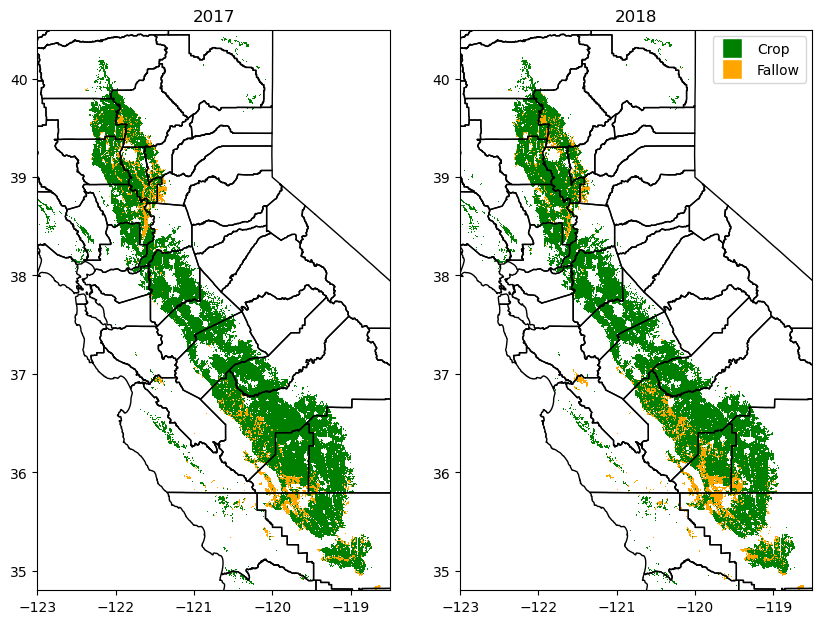

In [19]:
# Plotting

cmap_crop = pltc.ListedColormap([(0,0,0,0),"green"])
cmap_fallow = pltc.ListedColormap([(0,0,0,0),"orange"])

fig, ax = plt.subplots(1,2,figsize=(10, 20))

legend_elements = [Line2D([0], [0], marker='s', color='w', label='Crop',
                          markerfacecolor='green', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='Fallow',
                          markerfacecolor='orange', markersize=15),]

show(r_crops_17, ax=ax[0],cmap=cmap_crop)
show(r_fallow_17, ax=ax[0],cmap=cmap_fallow)

CA.plot(ax=ax[0], facecolor='none', edgecolor='black')
ax[0].set_title("2017")
ax[0].set_xlim(-123,-118.5)
ax[0].set_ylim(34.8,40.5)

show(r_crops_18, ax=ax[1],cmap=cmap_crop)
show(r_fallow_18, ax=ax[1],cmap=cmap_fallow)

CA.plot(ax=ax[1], facecolor='none', edgecolor='black')
ax[1].set_title("2018")
ax[1].set_xlim(-123,-118.5)
ax[1].set_ylim(34.8,40.5)

ax[1].legend(handles=legend_elements, loc='upper right')

# 4

In [20]:
# Percentage of cropped and fallow land in each year

crop_fallow = pd.DataFrame()

r_cf_17 = r_crops_17.read(1) + r_fallow_17.read(1)*2
cf_17 = pd.Series(r_cf_17.flatten()).value_counts()[1:]
crop_fallow[2017] = (cf_17/cf_17.sum())*100

r_cf_18 = r_crops_18.read(1) + r_fallow_18.read(1)*2
cf_18 = pd.Series(r_cf_18.flatten()).value_counts()[1:]
crop_fallow[2018] = (cf_18/cf_18.sum())*100

crop_fallow.index = ["Crop Land", "Fallow Land"]
crop_fallow = round(crop_fallow, 2)

print(crop_fallow)

              2017   2018
Crop Land    83.61  79.97
Fallow Land  16.39  20.03


- The percentage of cropped land was 83.61% in 2017 and 79.97% in 2018
- The percentage of fallowed land was 16.39% in 2017 and 20.03% in 2018

In [21]:
# Crop rotations

crop_to_fallow = (r_cf_17==1)&(r_cf_18==2)
fallow_to_crop = (r_cf_17==2)&(r_cf_18==1)
crop_to_crop = (r_cf_17==1)&(r_cf_18==1)
fallow_to_fallow = (r_cf_17==2)&(r_cf_18==2)

# Empty matrix
mat = np.zeros(r_cf_17.shape)

mat[crop_to_crop] = 1 
mat[crop_to_fallow] = 2
mat[fallow_to_fallow] = 3
mat[fallow_to_crop] = 4 

mat_flattened = mat.flatten()

rotate_pix_counts = pd.Series(mat_flattened).value_counts()

rotations = (rotate_pix_counts.iloc[1:]/rotate_pix_counts.iloc[1:].sum())*100
rotations.sort_index(inplace=True)

rotations.index = ["Crop to Crop","Crop to Fallow","Fallow to Fallow","Fallow to Crop"]

rotations = round(rotations, 2)

print(rotations)

Crop to Crop        74.93
Crop to Fallow       8.79
Fallow to Fallow    11.04
Fallow to Crop       5.24
dtype: float64


According to this,

- 74.93% of pixels were crops and stayed crops 
- 8.79% of pixels were crops and then became fallowed
- 11.04% of pixels were fallowed and stayed fallowed
- 5.24% of pixels were fallowed and then became crops

In [22]:
# Cropped to fallowed and fallowed to cropped rotations 

crop_pix = rotate_pix_counts.loc[[1,2]].reset_index(drop=True)
fallow_pix = rotate_pix_counts.loc[[3,4]].reset_index(drop=True)

transitions = pd.DataFrame()

transitions['Crop'] = (crop_pix/crop_pix.sum())
transitions['Fallow'] = fallow_pix/fallow_pix.sum()
transitions.index = ["Crop","Fallow"]
transitions = round(transitions * 100, 2)

print(transitions)

        Crop  Fallow
Crop    89.5   67.83
Fallow  10.5   32.17


10.50% of cropland from 2017 became fallowed, but 67.83% of fallow land from 2017 became cropped

# 5

In [23]:
# Raster using CDL layers

img_out = mat[np.newaxis,:,:].astype(np.uint8)
    
out_meta = r_crops_17.meta.copy()

out_meta['height'] = img_out.shape[1]
out_meta['width'] = img_out.shape[2]
out_meta['transform'] = r_crops_17.transform
out_meta['dtype'] = "uint8"

filename = "rotate_raster"

with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
    dest.write(img_out)
    
rotate_raster = rasterio.open("./"+filename+".tif")

# My Submission

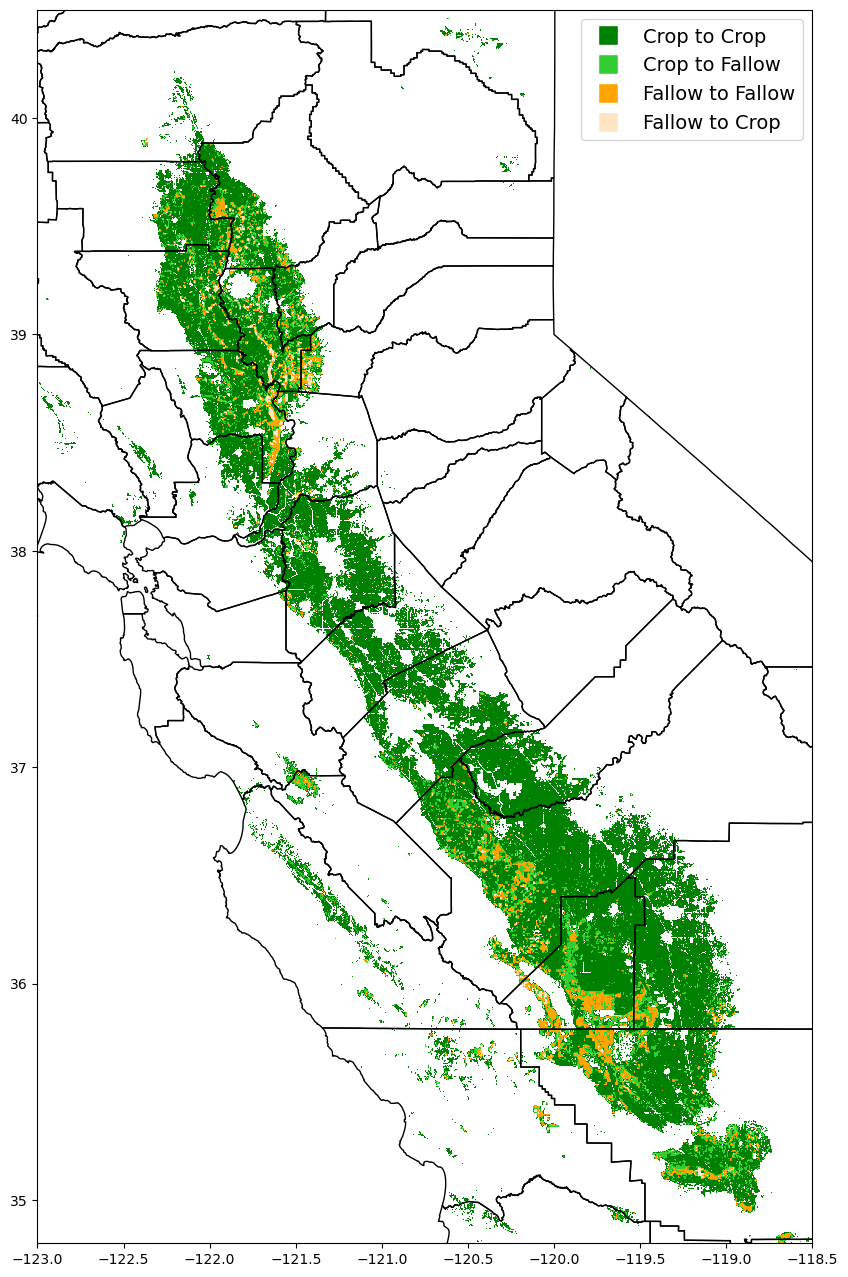

In [24]:
# Plotting

cmap_rotation = pltc.ListedColormap([(0,0,0,0),"green","limegreen","orange","bisque"])

fig, ax = plt.subplots(figsize=(10, 20))
show(rotate_raster, ax=ax,cmap=cmap_rotation)
CA.plot(ax=ax, facecolor='none', edgecolor='black')

legend_elements = [Line2D([0], [0], marker='s', color='w', label='Crop to Crop',
                          markerfacecolor="green", markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='Crop to Fallow',
                          markerfacecolor="limegreen", markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='Fallow to Fallow',
                          markerfacecolor="orange", markersize=15),
                  Line2D([0], [0], marker='s', color='w', label='Fallow to Crop',
                          markerfacecolor="bisque", markersize=15)]

ax.set_xlim(-123,-118.5)
ax.set_ylim(34.8,40.5)

ax.legend(handles=legend_elements, loc='upper right',fontsize=14)

Majority of land in the map belongs to the crop to crop category which indicates crop rotation. A few patches of crop to fallow rotation can be seen in the lower part of the plot. A decent number of fallow to fallow patches can be seen throughout the map. These areas might not be suitable for crop cultivation. These areas can be water bodies like rivers and lakes, or densely urban areas like cities. The amount of fallow to crop patches are very less but can be seen in some areas in the map.

# 6

In [25]:
# PRISM annual precipitation raster

P17 = rasterio.open("PRISM_ppt_stable_4kmM3_2017_bil.bil")

src_file = "PRISM_ppt_stable_4kmM3_2017_bil.bil"
dst_file = 'Prism_reproj.tif'
dst_crs = rasterio.crs.CRS.from_dict({'init': 'EPSG:4326'})

with rasterio.open(src_file) as src: 
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds) 
    kwargs = src.meta.copy() 
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open(dst_file, 'w', **kwargs) as dst: 
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            
P17 = rasterio.open("./Prism_reproj.tif")

P17 = clip_raster(P17,CA_State,"CA17_ppt")

CA_ppt = zonal_stats(CA, "./Prism_reproj.tif")
ppt_df = pd.DataFrame(CA_ppt)

<AxesSubplot:>

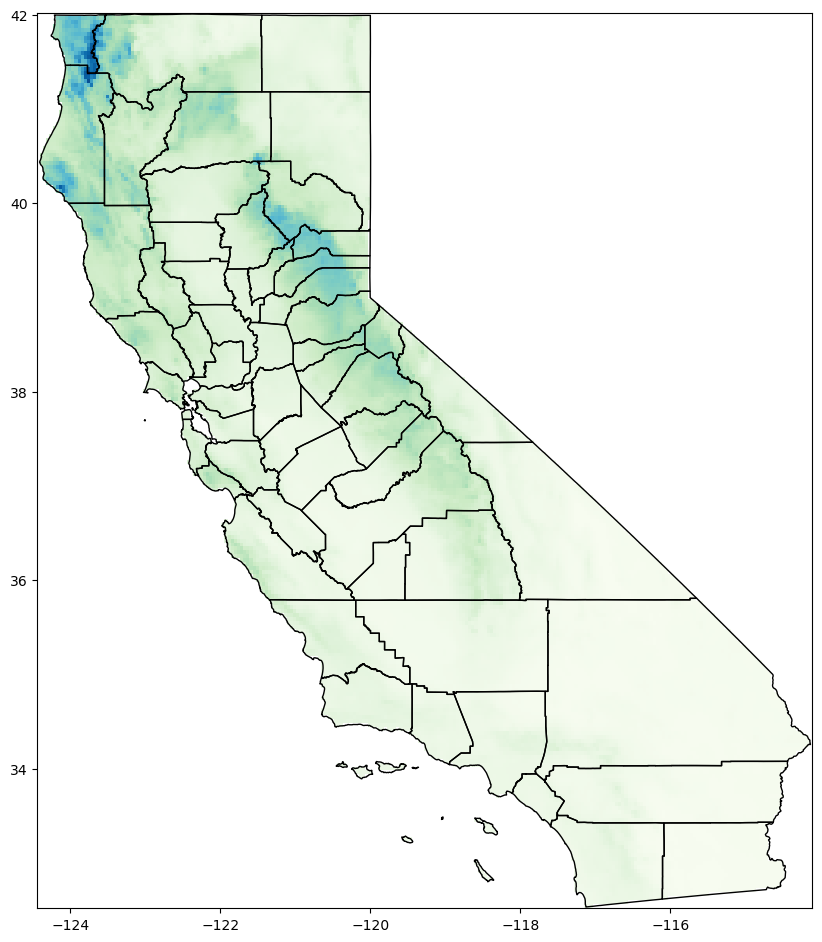

In [26]:
# Plotting precipitation

fig, ax = plt.subplots(figsize=(10, 20))

show(P17, ax=ax,cmap="GnBu")
CA.plot(ax=ax, facecolor='none', edgecolor='black')

In [27]:
# Country level percentage of cropped and fallow pixels

F_to_C_mat = np.zeros(mat.shape)
C_to_F_mat = np.zeros(mat.shape)

F_to_C_mat[mat == 4] = 1
F_to_C_mat[mat == 0] = 2

C_to_F_mat[mat == 2] = 1
C_to_F_mat[mat == 0] = 2

img_out = F_to_C_mat[np.newaxis,:,:].astype(np.uint8)
    
out_meta = r_crops_17.meta.copy()

out_meta['height'] = img_out.shape[1]
out_meta['width'] = img_out.shape[2]
out_meta['transform'] = r_crops_17.transform
out_meta['dtype'] = "uint8"

filename = "F_to_C_raster"

with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
    dest.write(img_out)
    
fallow_raster = rasterio.open("./"+filename+".tif")

img_out = C_to_F_mat[np.newaxis,:,:].astype(np.uint8)
    
out_meta = r_crops_17.meta.copy()

out_meta['height'] = img_out.shape[1]
out_meta['width'] = img_out.shape[2]
out_meta['transform'] = r_crops_17.transform
out_meta['dtype'] = "uint8"

filename = "C_to_F_raster"

with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
    dest.write(img_out)
    
fallow_raster = rasterio.open("./"+filename+".tif")

In [28]:
# Using zonal stats

CA_F_to_C = zonal_stats(CA, "./F_to_C_raster.tif",nodata=2)

CA_C_to_F = zonal_stats(CA, "./C_to_F_raster.tif",nodata=2)

F_to_C_df = pd.DataFrame(CA_F_to_C)
C_to_F_df = pd.DataFrame(CA_C_to_F)

CA['ppt_17'] = ppt_df['mean'].values
CA['fallow_to_crop'] = F_to_C_df['mean'].values
CA['crop_to_fallow'] = C_to_F_df['mean'].values

(34.8, 40.5)

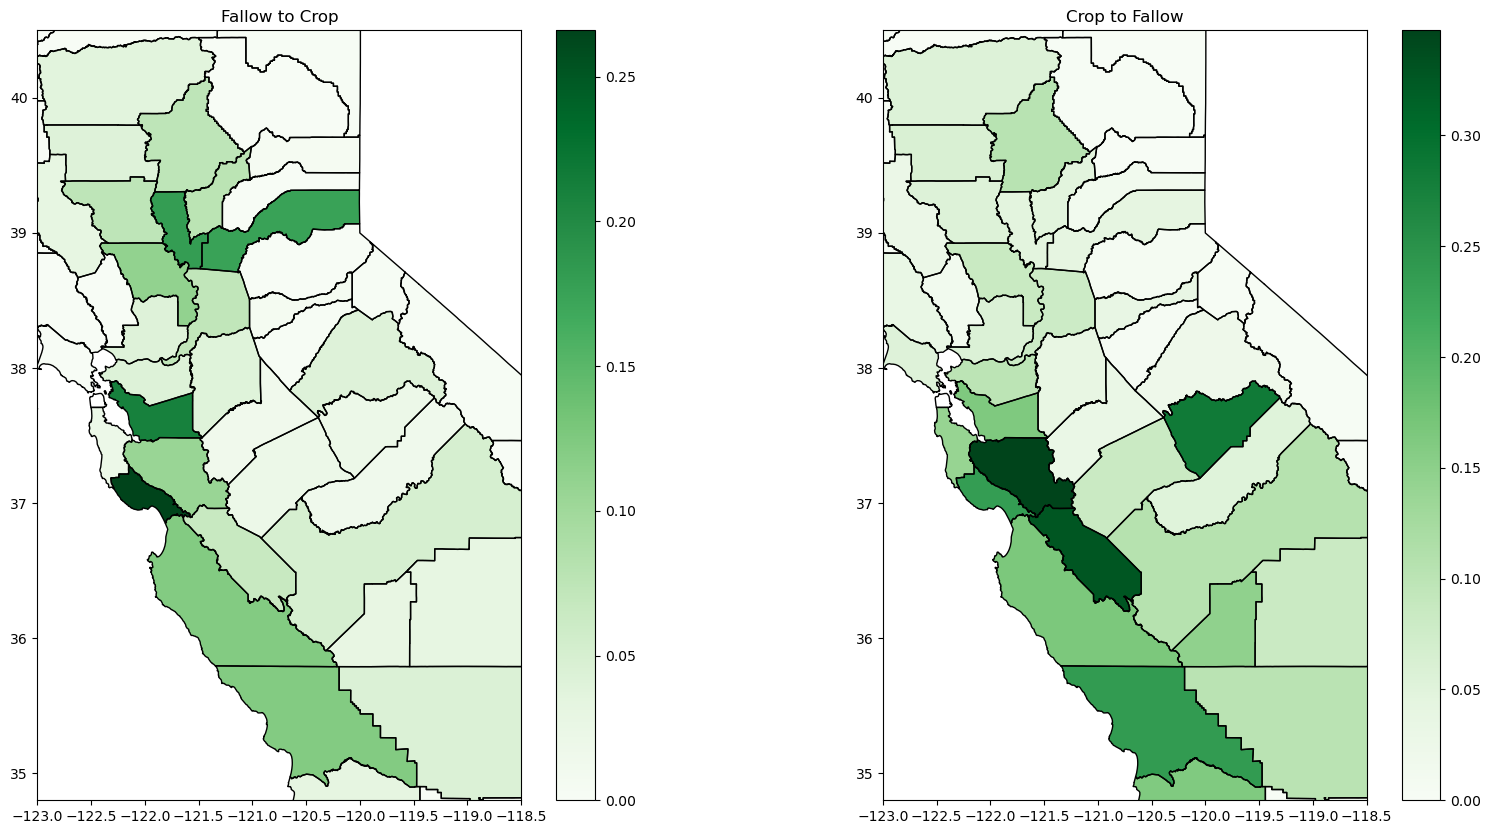

In [29]:
# PLotting

fig, ax = plt.subplots(1,2,figsize=(20,10))
CA.plot(column="fallow_to_crop",ax=ax[0],legend=True,cmap="Greens")
CA.plot(ax=ax[0],facecolor='none', edgecolor='black')

ax[0].set_title("Fallow to Crop")
ax[0].set_xlim(-123,-118.5)
ax[0].set_ylim(34.8,40.5)

CA.plot(column="crop_to_fallow",ax=ax[1],legend=True,cmap="Greens")
ax[1].set_title("Crop to Fallow")
CA.plot(ax=ax[1],facecolor='none', edgecolor='black')

ax[1].set_xlim(-123,-118.5)
ax[1].set_ylim(34.8,40.5)

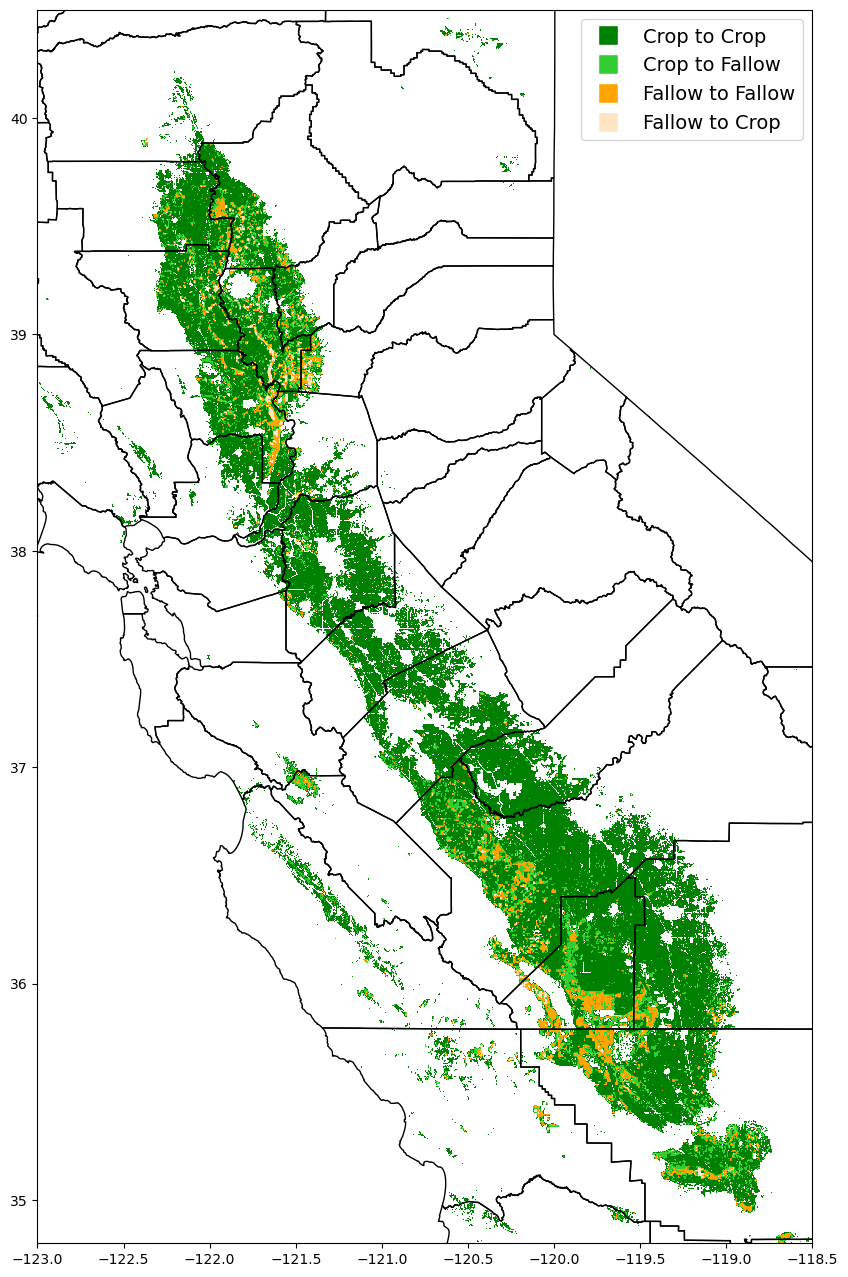

In [30]:
# Plot of various rotation categories

cmap_rotation = pltc.ListedColormap([(0,0,0,0),"green","limegreen","orange","bisque"])

fig, ax = plt.subplots(figsize=(10, 20))
show(rotate_raster, ax=ax,cmap=cmap_rotation)
CA.plot(ax=ax, facecolor='none', edgecolor='black')

legend_elements = [Line2D([0], [0], marker='s', color='w', label='Crop to Crop',
                          markerfacecolor="green", markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='Crop to Fallow',
                          markerfacecolor="limegreen", markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='Fallow to Fallow',
                          markerfacecolor="orange", markersize=15),
                  Line2D([0], [0], marker='s', color='w', label='Fallow to Crop',
                          markerfacecolor="bisque", markersize=15)]

ax.set_xlim(-123,-118.5)
ax.set_ylim(34.8,40.5)

ax.legend(handles=legend_elements, loc='upper right',fontsize=14)

In [31]:
# Correlation

cor = CA.corr()
cor = round(cor, 3)

print(cor)

                ALAND  AWATER  ppt_17  fallow_to_crop  crop_to_fallow
ALAND           1.000   0.044  -0.335          -0.245          -0.206
AWATER          0.044   1.000  -0.098          -0.087           0.008
ppt_17         -0.335  -0.098   1.000          -0.064          -0.211
fallow_to_crop -0.245  -0.087  -0.064           1.000           0.558
crop_to_fallow -0.206   0.008  -0.211           0.558           1.000


# 7

<b>1) What data sources you would need in addition to the data you have now?</b>

- <b>Rainfall in 2017:</b> We would need data on the amount of rainfall that occurred in the Central Valley of California in 2017. This data can be obtained from weather stations located in the region or from satellite-based rainfall estimates.
- <b>Land use in 2016:</b> To determine the extent of fallowing in 2017, we would need data on land use in the Central Valley in the previous year (2016). This can be obtained from the Cropland Data Layer (CDL) or other land use datasets.
- <b>Land use in 2018:</b> To determine the conversion of fallowed land to crop land in 2018, we would need data on land use in that year. This can be obtained from the CDL or other land use datasets.
- <b>Other relevant variables:</b> Other variables that might be relevant to this analysis include soil type, crop prices, and farm management practices. Data on these variables can help to better understand the relationship between rainfall and fallowing/conversion to crops.

<b>2) How you would manipulate the data?</b>

- <b>Merge datasets:</b> We would first merge the CDL data for 2016, 2017, and 2018 into a single dataset. We would also merge the rainfall data for 2017 into this dataset.
- <b>Calculate fallowing and conversion rates:</b> Using the merged dataset, we could calculate the fallowing rate in 2017  and the conversion rate in 2018.
- <b>Perform statistical analysis:</b> We could then perform statistical analysis to explore the relationship between rainfall in 2017 and the fallowing and conversion rates. For example, we could use regression analysis to examine the relationship between rainfall and fallowing/conversion rates, controlling for other relevant variables such as soil type, crop prices, and farm management practices.
- <b>Visualize the results:</b> Finally, we would visualize the results of our analysis using maps and graphs to better understand the spatial patterns and trends in fallowing and conversion rates, and how they are related to rainfall in 2017.

<b>3) What statistics you would calculate or model you would run on this data?</b>
    
- <b>Descriptive statistics:</b> We could calculate means, medians, and standard deviations for the fallowing and conversion rates in the Central Valley of California in 2017 and 2018. These statistics would give us a sense of the overall patterns and trends in fallowing and conversion rates, and how they vary across the region.
- <b>Correlation analysis:</b> We could calculate the correlation coefficient between rainfall in 2017 and fallowing and conversion rates in 2017 and 2018. This would allow us to examine the strength and direction of the relationship between rainfall and fallowing/conversion rates.
- <b>Regression analysis:</b> We could run regression analysis to model the relationship between rainfall in 2017 and fallowing and conversion rates in 2017 and 2018, controlling for other relevant variables such as soil type, crop prices, and farm management practices. This would allow us to estimate the effect of rainfall on fallowing and conversion rates, while accounting for the effects of other factors that might also influence these rates.
- <b>Spatial analysis:</b> We could conduct spatial analysis to explore the spatial patterns and trends in fallowing and conversion rates in the Central Valley of California, and how they relate to rainfall in 2017. This could involve mapping the fallowing and conversion rates at the county or sub-county level, and examining how these rates vary across the region in relation to rainfall patterns.

<b>4) How you might present your findings?</b>

- <b>Maps:</b> We could create maps of the Central Valley of California showing the spatial patterns of fallowing and conversion rates in 2017 and 2018, as well as the distribution of rainfall in 2017. We could use color-coding or other visual cues to highlight areas with high or low fallowing and conversion rates, and how they correspond to areas with high or low rainfall.
- <b>Bar charts and line charts:</b> We could create bar charts or line charts to compare the fallowing and conversion rates in 2017 and 2018 across different counties or sub-counties in the Central Valley of California. We could also create line charts to show how rainfall in 2017 varied over time, and how it might have influenced fallowing and conversion rates in 2018.
- <b>Statistical summaries:</b> We could summarize our findings using statistical measures such as means, medians, standard deviations, and correlation coefficients. For example, we could report the correlation coefficient between rainfall in 2017 and fallowing and conversion rates in 2018, and how statistically significant this relationship is.
- <b>Narrative summaries:</b> We could present our findings in a narrative format, using text and visuals to describe the main patterns and trends we observed, and how they relate to rainfall in 2017. We could also discuss the limitations of our analysis, such as the potential influence of unmeasured variables, and suggest directions for future research.

<b>5) What factors would make it difficult to accurately answer this question?<b>

- <b>Data quality and availability:</b> There might be missing or incomplete data on fallowing and conversion rates, or rainfall data might not be available at a fine enough spatial or temporal resolution to capture local variations in weather patterns. Such limitations in data quality and availability could make it difficult to draw reliable conclusions about the relationship between rainfall and fallowing/conversion rates.
- <b>Confounding factors:</b> Confounding factors are variables that are correlated with both the independent variable (rainfall) and the dependent variable (fallowing/conversion rates), making it difficult to attribute changes in the dependent variable solely to the independent variable. 
- <b>Causal inference:</b> While statistical models can be used to estimate the relationship between rainfall and fallowing/conversion rates, inferring causality is challenging. This is because there may be other factors that influence both rainfall and fallowing/conversion rates, and the direction of causality may not be clear. 